<a href="https://colab.research.google.com/github/matthiasweidlich/conf_tutorial/blob/master/rules_replay_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On Exercise 2: Rule Checking and Replay-based Conformance

In this exercise, you will take up the real-life event log of a Dutch financial institute, known already from the earlier notebook. Be reminded that you should be able to clone the repository containing the notebooks and the example data with the code in the next cell. If this does not work, however, you can also download the event log (XES format, please unzip) [here](http://www.win.tue.nl/bpi/doku.php?id=2012:challenge) and then either copy it to your google drive, mount it, and read it from there, or directly upload it using your browser.

Also, further details can be found in the [description of the dataset](http://www.win.tue.nl/bpi/doku.php?id=2012:challenge).

In [0]:
# basic configuration
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# import data from google drive
#from google.colab import drive
#drive.mount('/content/drive')

# direct data upload
#from google.colab import files
#files.upload()

# clone the repository that contains the notebooks and also the data file
! git clone https://github.com/matthiasweidlich/conf_tutorial.git

Cloning into 'conf_tutorial'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 55 (delta 25), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (55/55), done.


## Import Event Log
The following method imports the log file and returns it in a list structure.

In [0]:
import xml.etree.ElementTree as et

def load_xes(file, event_filter = []):
    log = []
    
    tree = et.parse(file)
    data = tree.getroot()
    
    # find all traces
    traces = data.findall('{http://www.xes-standard.org/}trace')
    
    for t in traces:
        trace_id = None
        
        # get trace id
        for a in t.findall('{http://www.xes-standard.org/}string'):
            if a.attrib['key'] == 'concept:name':
                trace_id = a.attrib['value']
        
        events = []
        # events
        for event in t.iter('{http://www.xes-standard.org/}event'):
            
            e = {'name': None, 'timestamp': None, 'resource': None, 'transition': None}
            
            for a in event:
                e[a.attrib['key'].split(':')[1]] = a.attrib['value']
            
            if e['name'] in event_filter or len(event_filter) == 0:
                events.append(e)
        
        # add trace to log
        if len(events) > 0:
            log.append({'trace_id': trace_id, 'events': events})
        
    return log

Now import the given log and compute the trace variants of the log along with their frequencies.

In [0]:
from pprint import pprint

log_file = 'conf_tutorial/financial_log.xes'
log = load_xes(log_file)

print('Load log with %s traces.' %len(log))

trace_variants = {}
for trace in log:
    events = []
    for event in trace['events']:
        events.append(event['name'])
    trace_variants[tuple(events)] = trace_variants.get(tuple(events), 0) + 1
    
# print the two most frequent variants
trace_variants_sorted_by_freq = sorted(trace_variants.items(), key=lambda kv: kv[1], reverse=True)
pprint(trace_variants_sorted_by_freq[:2])

Load log with 13087 traces.
[(('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED'), 3429),
 (('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'A_DECLINED',
   'W_Afhandelen leads'),
  1872)]


## Import Process Model

For the log, a process model is given in the form of a Petri net. Such a process model is typically created manually. For this particular example, however, the model has been discovered automatically using the Inductive Miner, applying some noise filtering threshold. 

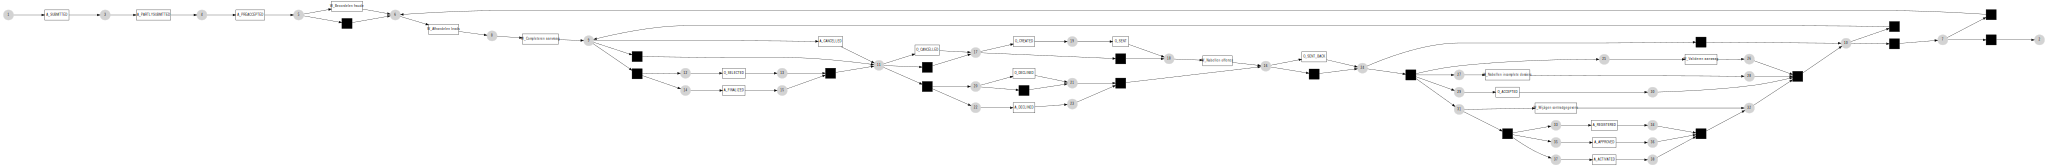

In [0]:
%run ./conf_tutorial/pn.py

net = PetriNet()
load(net, "./conf_tutorial/financial_log_80_noise.pnml")

# mark the initial place
net.add_marking(1,1)
# visualise it 
draw_petri_net(net)

Set up some helper dictionaries to relate transition IDs (from the Petri net) and activity labels to each other. Observe that an activity label is only assigned to a single transition. However, multiple transitions may carry a _tau_ label, representing a silent transition.



In [0]:
# helper mappings between ids and labels
mapping = net.get_mapping()
rev_mapping = {}
for k, v in net.get_mapping().items():
    for k2 in v:
        rev_mapping[k2] = k

from pprint import pprint
# mapping from labels to LISTS of transitions ids
pprint(mapping)

# mapping from transitions id to label
pprint(rev_mapping)


{'A_ACTIVATED': [-37],
 'A_APPROVED': [-36],
 'A_CANCELLED': [-13],
 'A_DECLINED': [-24],
 'A_FINALIZED': [-12],
 'A_PARTLYSUBMITTED': [-2],
 'A_PREACCEPTED': [-3],
 'A_REGISTERED': [-35],
 'A_SUBMITTED': [-1],
 'O_ACCEPTED': [-32],
 'O_CANCELLED': [-15],
 'O_CREATED': [-17],
 'O_DECLINED': [-23],
 'O_SELECTED': [-11],
 'O_SENT': [-18],
 'O_SENT_BACK': [-26],
 'W_Afhandelen leads': [-6],
 'W_Beoordelen fraude': [-5],
 'W_Completeren aanvraag': [-7],
 'W_Nabellen incomplete dossiers': [-31],
 'W_Nabellen offertes': [-19],
 'W_Valideren aanvraag': [-30],
 'W_Wijzigen contractgegevens': [-38],
 'tau': [-4,
         -8,
         -9,
         -10,
         -14,
         -16,
         -20,
         -21,
         -22,
         -25,
         -27,
         -28,
         -29,
         -33,
         -34,
         -39,
         -40,
         -41,
         -42]}
{-42: 'tau',
 -41: 'tau',
 -40: 'tau',
 -39: 'tau',
 -38: 'W_Wijzigen contractgegevens',
 -37: 'A_ACTIVATED',
 -36: 'A_APPROVED',
 -35: 'A

Next, we illustrate how, given an initial marking, the currently enabled transitions may be identified, how the marking is changed by firing a transition, and how the marking may be adapted to enable a transition. 

In [0]:
print("Initial marking: ", net.get_marking())

enabled = net.all_enabled_transitions()
print("Enabled transitions in initial marking: ", 
      list(map((lambda k: rev_mapping[k]), enabled)))

# Fire enabled transition (take the first, but there is only one)
net.fire_transition(enabled[0])
enabled = net.all_enabled_transitions()
print("Enabled transitions after firing first transition: ", 
      list(map((lambda k: rev_mapping[k]), enabled)))

# Check whether the transition with label 'O_CREATED' is enabled 
# (there is only one transition carrying this label)
print("Is transition 'O_CREATED' enabled?", 
      net.is_enabled(net.get_mapping()['O_CREATED'][0]))

# Enable the transition by changing the marking and adding tokens to the input 
# places of the transition with label 'O_CREATED' 
input_places = net.get_input_places(net.get_mapping()['O_CREATED'][0])

for p in input_places:
    net.add_marking(p,1)

# Again, check whether the transition with label 'O_CREATED' is enabled 
print("Is transition 'O_CREATED' enabled after tokens have been added to the places in its preset?", 
      net.is_enabled(net.get_mapping()['O_CREATED'][0]))

# Check whether further transitions have been enabled by adding the token to 
# the places in the preset of the transition with label 'O_CREATED'
enabled = net.all_enabled_transitions()
print("Enabled transitions after adapting the marking: ", 
      list(map((lambda k: rev_mapping[k]), enabled)))

print("Current marking: ", net.get_marking())




Initial marking:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Enabled transitions in initial marking:  ['A_SUBMITTED']
Enabled transitions after firing first transition:  ['A_PARTLYSUBMITTED']
Is transition 'O_CREATED' enabled? False
Is transition 'O_CREATED' enabled after tokens have been added to the places in its preset? True
Enabled transitions after adapting the marking:  ['A_PARTLYSUBMITTED', 'tau', 'O_CREATED']
Current marking:  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Rule Checking

First, we assess the conformance of the given event log and process model using rules that are derived from the model. Specifically, we consider a cardinality rule that checks a lower and an upper bound for the number of executions of an activity for a particular trace, as well as an ordering rule that checks whether executions of one activity happen only after executions of another activity.

**Task:** Complete the following functions to check the respective rules in a rather generic manner. 

In [0]:
def check_lower_bound(trace: [], act: str, bound: int) -> bool:
    count = trace.count(act)
    return count >= bound

def check_upper_bound(trace: [], act: str, bound: int) -> bool:
    count = trace.count(act)
    return count <= bound

def check_order_after(trace: [], act_1: str, act_2: str) -> bool:
    if act_1 not in trace or act_2 not in trace:
      return True
    idx_1 = [i for i, x in enumerate(trace) if x == act_1]
    idx_2 = [i for i, x in enumerate(trace) if x == act_2]
    return idx_1[0] >= idx_2[-1]



Check whether the five most frequent trace variants actually satisfy the following rules:


*   The application is completed at least once (activity "W_Completeren aanvraag").
*   The application is submitted at most once (activity "A_SUBMITTED").
*   The income lead ("W_Afhandelen leads") is fixed only after the preacceptance ("A_PREACCEPTED"), but never before. 



In [0]:
for k in range(5):
    trace_k = list(trace_variants_sorted_by_freq[k][0])
    print("Checking trace: %s" % trace_k)
    print("Application completed at least once? ", check_lower_bound(trace_k, 'W_Completeren aanvraag', 1))
    print("Application submitted at most once? ", check_upper_bound(trace_k, 'A_SUBMITTED', 1))
    print("Fixing income lead only after preaceptance? ", check_order_after(trace_k, 'W_Afhandelen leads', 'A_PREACCEPTED'))

Checking trace: ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED']
Application completed at least once?  False
Application submitted at most once?  True
Fixing income lead only after preaceptance?  True
Checking trace: ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads']
Application completed at least once?  False
Application submitted at most once?  True
Fixing income lead only after preaceptance?  True
Checking trace: ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads']
Application completed at least once?  False
Application submitted at most once?  True
Fixing income lead only after preaceptance?  True
Checking trace: ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_PREACCEPTED', 'W_Completeren aanvraag', 'W_Afhandelen leads', 'W_Completeren aanvraag', 'A_DECLINED', 'W_Completere

## Replay-based Conformance

Next, consider replay-based conformance checking. 

**Task:** The following function shall take a Petri net and a trace and replay it. It shall return the numbers of produced, consumed, missing, and remaining tokens. 

In [0]:

def replay_trace(net: PetriNet, trace: []) -> (int, int, int, int):
    produced = 1
    consumed = 1
    missing = 0

    # replay trace, event by event
    for event in trace:
        # identify transition, assumption here is that there is only one transition for the label
        transition = net.get_mapping()[event][0]
        # check if the transition is enabled
        if not net.is_enabled(transition):
            # not enabled, so add a token to all input places that are not marked
            for p in net.get_input_places(transition):
                if net.marking[net.index_of_place(p)] == 0:
                    # record the token as missing
                    missing += 1
                    net.add_marking(p, 1)

        # record the numbers produced and consumed tokens when firing the transition
        produced += len(net.get_input_places(transition))
        consumed += len(net.get_output_places(transition))
        net.fire_transition(transition)

    # we expect one token left, everything else counts as remaining
    remaining = sum(net.get_marking()) - 1
    return produced, consumed, missing, remaining


def fitness(net: PetriNet, log_freq: dict) -> float:
    sum_prod = 0
    sum_cons = 0
    sum_miss = 0
    sum_rema = 0

    for trace_var, freq in log_freq.items():
        # keep copy of marking
        marking = list(net.get_marking())
        # replay trace
        replay_values = replay_trace(net, trace_var)
        sum_prod += log_freq[trace_var] * replay_values[0]
        sum_cons += log_freq[trace_var] * replay_values[1]
        sum_miss += log_freq[trace_var] * replay_values[2]
        sum_rema += log_freq[trace_var] * replay_values[3]
        # restore marking
        for k,v in net.places.items():
            net.add_marking(v, marking[k])

    return 0.5 * (1 - sum_miss / sum_cons) + 0.5 * (1 - sum_rema / sum_prod)

Measure fitness of the most frequent trace variant: 

In [0]:
log_1 = {t[0]:t[1] for t in trace_variants_sorted_by_freq[0:1]}
fitness_value = fitness(net, log_1)
print("Fitness value of most frequent trace variant:", fitness_value)

Fitness value of most frequent trace variant: 0.375


Now, see how the fitness value changes when considering the _k_-most frequent trace variants.

In [0]:
fitness_value = 0
for k in range(30):
    log_k = {t[0]:t[1] for t in trace_variants_sorted_by_freq[k:k+1]}
    log_x = {t[0]:t[1] for t in trace_variants_sorted_by_freq[0:k+1]}
    fitness_value_k = fitness(net, log_k)
    fitness_value = fitness(net, log_x)
    print("Fitness value of the single %s-most frequent trace variant: %f" % (k+1, fitness_value))
    print("Fitness value of %s-most frequent trace variants: %f" % (k+1, fitness_value))

Fitness value of the single 1-most frequent trace variant: 0.375000
Fitness value of 1-most frequent trace variants: 0.375000
Fitness value of the single 2-most frequent trace variant: 0.296477
Fitness value of 2-most frequent trace variants: 0.296477
Fitness value of the single 3-most frequent trace variant: 0.285656
Fitness value of 3-most frequent trace variants: 0.285656
Fitness value of the single 4-most frequent trace variant: 0.301271
Fitness value of 4-most frequent trace variants: 0.301271
Fitness value of the single 5-most frequent trace variant: 0.301708
Fitness value of 5-most frequent trace variants: 0.301708
Fitness value of the single 6-most frequent trace variant: 0.306001
Fitness value of 6-most frequent trace variants: 0.306001
Fitness value of the single 7-most frequent trace variant: 0.311396
Fitness value of 7-most frequent trace variants: 0.311396
Fitness value of the single 8-most frequent trace variant: 0.309831
Fitness value of 8-most frequent trace variants: 0

##-- End